In [23]:
# import pyomo.environ as pyo
import pandas as pd
from pathlib import Path
from utils.distfit import *
from utils.scenario_gen import *
from utils.clustering import *
from scipy.spatial.distance import pdist, cdist
import numpy as np
import scipy as sp
import copy
import itertools
from joblib import Parallel, delayed

In [24]:
datapath = Path(Path().resolve().parents[2]) / 'data'
savepath = datapath / 'forecast data' / 'Scenarios'
distpath = datapath / 'forecast data' / 'Distributions'
tpepath = datapath / 'forecast data' / 'TPE Search results'

waterboards = ['HHNK', 'HDSR', 'Rijnland', 'Waternet']


In [25]:
datapath

WindowsPath('D:/Users/Heijden/Documents/PhD work/Current work/DR_IJmuiden/data')

In [26]:
def get_tpepath(name, tpepath):
    if name in waterboards:
        return tpepath / 'CQRDNN_Waterboards' / name / 'Forecasts'
    elif name == 'WL':
        return tpepath / 'CQRDNN_WL_IJmuiden' / 'Forecasts'
    elif name == 'DAM':
        return tpepath / 'CQRDNN_DAM' / 'Forecasts'
    else:
        raise ValueError(f'Invalid name: {name}')
    
def get_data(name, tpepath, distpath):
    path = get_tpepath(name, tpepath)
    if name == 'DAM':
        val_data = pd.concat([pd.read_pickle(path / 'y_train.pkl'), pd.read_pickle(path / 'y_val.pkl')], axis=0).astype(float).sort_index()
        val_data = val_data.loc[:, [col for col in val_data.columns if ('q0.5' in col) and ('NL' in col)]]
        val_data.columns = [f'DAM NL +{h}' for h in range(1,49)]
        distribution_df_ = pd.read_pickle(get_distpath(name, distpath))
        # distribution_df_ = pd.read_csv(get_distpath(name), index_col=[0,1], parse_dates=True, header=[0,1])
        forecast_times = distribution_df_.index.droplevel(1)#.unique()
        observation_times = distribution_df_.index.droplevel(0)#.unique()
        index = pd.MultiIndex.from_tuples([
            # substract 1 day from the observation time and 1h from the forecast time as little hack for the BN later on
            # this results in the same index for the BN as the 1-48h forecasts (t+1h:t+49h)
            (fctime+pd.DateOffset(hours=-1), obstime+pd.DateOffset(days=-1)+pd.DateOffset(hours=h)) for (fctime, obstime) in zip(forecast_times, observation_times) for h in range(0, 24)
        ])
        distribution_df = pd.DataFrame(
            index=index,
            columns=['dist', 'params', 'KS'],
        )
        idx=pd.IndexSlice
        for i, (fctime, obstime) in enumerate(zip(forecast_times, observation_times)):
            distribution_df.iloc[i*24:(i+1)*24, 0] = distribution_df_.loc[idx[fctime, obstime], idx[:, 'dist']].values
            distribution_df.iloc[i*24:(i+1)*24, 1] = distribution_df_.loc[idx[fctime, obstime], idx[:, 'params']].values
            distribution_df.iloc[i*24:(i+1)*24, 2] = distribution_df_.loc[idx[fctime, obstime], idx[:, 'KS']].values
    
    else:
        if name in waterboards + ['WL']:
            f = 'y_train.csv'
        else:
            f = 'y_trainval.csv'
        val_data = pd.read_csv(path / f, index_col=0, parse_dates=True).astype(float)
        if name in waterboards:
            val_data = val_data.loc[:, [f'Aggregated +{i} q0.5' for i in range(1, 49)]]
            val_data.columns =  [f'Q +{i}' for i in range(1, 49)]
            
        elif name == 'WL':
            val_data = val_data.loc[:, [f'WL +{i} q0.5' for i in range(1, 49)]]
            val_data.columns =  [f'WL +{i}' for i in range(1, 49)]
        distribution_df = pd.read_pickle(get_distpath(name, distpath))
        #distribution_df = pd.read_csv(get_distpath(name), index_col=0, parse_dates=True, header=[0,1])
    return val_data, distribution_df
    
def get_distpath(name, distpath):
    if name in waterboards:
        return distpath / f'{name}.pkl'
    elif name == 'WL':
        return distpath / f'WL.pkl'
    elif name == 'DAM':
        return distpath / f'DAM.pkl'
    else:
        raise ValueError(f'Invalid name: {name}')

In [27]:
class ScenarioGenerator():
    def __init__(self, name, varname, valmin=None, valmax=None, scenario_mask=None, tpepath=None, distpath=None):
        self.name = name
        self.varname = varname
        self.val_data, self.distribution_df = get_data(name, tpepath, distpath)
        self.indices = self.distribution_df.index

        
        if self.name in ['Rijnland', 'Waternet', 'HDSR', 'HHNK']:
            self.scenario_mask = (0, self.val_data.max().max())
        elif self.name == 'WL':
            self.scenario_mask = (self.val_data.min().min(), self.val_data.max().max())
        else:
            self.scenario_mask = scenario_mask


        if valmin is None:
            self.valmin = np.floor(self.val_data.min().min() * 10) / 10 / 10
            self.valmax = np.ceil(self.val_data.max().max() * 10) / 10 * 10
        else:
            self.valmin = valmin
            self.valmax = valmax

        self.distributionloader = DistributionLoader(self.distribution_df, self.varname, valmin=self.valmin, valmax=self.valmax)
        self.make_bn()
    
    def make_bn(self):
        self.bn = BN(self.val_data, self.distributionloader, varname=self.varname, n=len(self.val_data.columns), threshold=None)
        self.bn.make_structure()

    def sample_scenarios(self, date, n=1000, BN=True, return_df=True):
        if BN:
            self.scenarios = self.bn.sample_BN(date, n).round(2)
        else:
            self.scenarios = pd.DataFrame(index=range(n), columns=self.val_data.columns)
            for col in self.val_data.columns:
                dist = self.distribution_df.loc[date, (col, 'dist')]
                params = self.distribution_df.loc[date, (col, 'params')]
                self.scenarios.loc[:, col] = get_rv(dist, params).rvs(n)

        if self.scenario_mask is not None:
            self.scenarios[self.scenarios < self.scenario_mask[0]] = self.scenario_mask[0]
            self.scenarios[self.scenarios > self.scenario_mask[1]] = self.scenario_mask[1]

        if return_df:
            return self.scenarios

    def cluster_scenarios(self, subset_size, method='energy', return_df=True):
        energy_clusterer = ReduceForward(x=self.scenarios.values, cdn=subset_size, dist=method, verbose=False)
        energy_clusterer.reduce_forward()
        self.clusters = energy_clusterer.clusters
        self.clusters.columns=[col for col in self.scenarios.columns] + ['weights']
        if return_df:
            return self.clusters
        
class DischargeGenerator():
    def __init__(self, scenario_generator_dict):
        self.waterboards = ['HHNK', 'Rijnland', 'Waternet', 'HDSR']
        self.scenario_generator_dict = scenario_generator_dict

    def sample_scenarios(self, date, n=1000, BN=True, return_df=True):
        self.wb_scenarios = {}
        for wb in self.waterboards:
            self.wb_scenarios[wb] = self.scenario_generator_dict[wb].sample_scenarios(date, n=n, return_df=True)
        
        if return_df:
            return self.wb_scenarios
    
    def cluster_wb_scenarios(self, subset_size, method='energy', return_df=True):
        # Cluster the individual waterboard scenarios
        ind = pd.MultiIndex.from_product([range(subset_size), self.waterboards], names=['cluster', 'waterboard'])
        cluster_cols = [col for col in self.wb_scenarios[self.waterboards[0]].columns] + ['weights']
        self.wb_clusters = pd.DataFrame(index=ind, columns=cluster_cols, dtype=float)
        self.idx = pd.IndexSlice
        for wb in self.waterboards:
            self.wb_clusters.loc[self.idx[:, wb], :] = self.scenario_generator_dict[wb].cluster_scenarios(subset_size, method=method, return_df=True).values
        
        if return_df:
            return self.wb_clusters
    
    def _sum_discharges(self, comb):
        return np.sum( np.array([
            self.wb_clusters.loc[self.idx[comb[i], wb], [col for col in self.wb_clusters.columns if col != 'weights']].values 
            for i, wb in enumerate(self.waterboards) ]), axis=0)

    def combine_clusters(self, subset_size, method='energy', return_df=True):
        combinations = list(itertools.product(*[range(len(self.wb_clusters.loc[self.idx[:, wb], :].index)) for wb in self.waterboards]))
        # res = Parallel(n_jobs=-1, verbose=1)(delayed(self._sum_discharges)(comb) for comb in combinations)
        # self.combined_scenarios = pd.DataFrame(res, columns=[col for col in self.wb_clusters.columns if col != 'weights'])
        self.combined_scenarios = pd.DataFrame(index=range(len(combinations)), columns=[col for col in self.wb_clusters.columns if col != 'weights'], dtype=float)
        for i, comb in enumerate(combinations):
            self.combined_scenarios.loc[i, :] = self._sum_discharges(comb)

        clusterer = ReduceForward(x=self.combined_scenarios.values, cdn=subset_size, dist=method, verbose=False)
        clusterer.reduce_forward()
        self.combined_clusters = clusterer.clusters
        self.combined_clusters.columns=[col for col in self.combined_scenarios.columns] + ['weights']
        if return_df:
            return self.combined_clusters

In [28]:
# def get_tpepath(name):
#     if name in waterboards:
#         return tpepath / 'CQRDNN_Waterboards' / name / 'Forecasts'
#     elif name == 'WL':
#         return tpepath / 'CQRDNN_WL_IJmuiden' / 'Forecasts'
#     elif name == 'DAM':
#         return tpepath / 'CQRDNN_DAM' / 'Forecasts'
#     else:
#         raise ValueError(f'Invalid name: {name}')
    
# def get_distpath(name):
#     if name in waterboards:
#         return distpath / f'{name}.pkl'
#     elif name == 'WL':
#         return distpath / f'WL.pkl'
#     elif name == 'DAM':
#         return distpath / f'DAM.csv'
#     else:
#         raise ValueError(f'Invalid name: {name}')
    
# def get_data(name):
#     path = get_tpepath(name)
#     if name == 'DAM':
#         val_data = pd.concat([pd.read_pickle(path / 'y_train.pkl'), pd.read_pickle(path / 'y_val.pkl')], axis=0).astype(float).sort_index()
#         val_data = val_data.loc[:, [col for col in val_data.columns if ('q0.5' in col) and ('NL' in col)]]
#         val_data.columns = [f'DAM NL +{h}' for h in range(1,49)]
#         distribution_df_ = pd.read_csv(get_distpath(name), index_col=[0,1], parse_dates=True, header=[0,1])
#         distribution_df_.index = distribution_df_.index.droplevel(1)
#         indices = np.array([i for i in range(0, len(distribution_df_.index), 2)])
#         distribution_df = pd.concat([distribution_df_.iloc[indices, :], distribution_df_.iloc[indices+1, :]], axis=1)
#         distribution_df.columns = pd.MultiIndex.from_product([[f'DAM NL_{i}' for i in range(1,49)], ['dist', 'params', 'KS']])
    
#     else:
#         if name == 'DAM':
#             f = 'y_trainval.csv'
#         else:
#             f = 'y_train.csv'
            
#         val_data = pd.read_csv(path / f, index_col=0, parse_dates=True).astype(float)
#         if name in waterboards:
#             val_data = val_data.loc[:, [f'Aggregated +{i} q0.5' for i in range(1, 49)]]
#             val_data.columns =  [f'Q +{i}' for i in range(1, 49)]
            
#         elif name == 'WL':
#             val_data = val_data.loc[:, [f'WL +{i} q0.5' for i in range(1, 49)]]
#             val_data.columns =  [f'WL +{i}' for i in range(1, 49)]
        
#         if name == 'DAM':
#             distribution_df = pd.read_csv(get_distpath(name), index_col=0, parse_dates=True, header=[0,1])
#         else:
#             distribution_df = pd.read_pickle(get_distpath(name))#, index_col=0, parse_dates=True, header=[0,1])
#     return val_data, distribution_df

In [29]:
idx = pd.IndexSlice

In [30]:
name = 'DAM'
val_data, distribution_df = get_data(name, tpepath=tpepath, distpath=distpath)

In [31]:
val_data.min().min()

-25.0

In [32]:
date = distribution_df.index[100][0]
date

Timestamp('2019-01-01 23:00:00+0000', tz='UTC')

In [33]:
class ScenarioGenerator():
    def __init__(self, name, varname, valmin=None, valmax=None, scenario_mask=None, tpepath=None, distpath=None):
        self.name = name
        self.varname = varname
        self.val_data, self.distribution_df = get_data(name, tpepath, distpath)
        self.indices = self.distribution_df.index

        
        if self.name in ['Rijnland', 'Waternet', 'HDSR', 'HHNK']:
            self.scenario_mask = (0, self.val_data.max().max())
        elif self.name == 'WL':
            self.scenario_mask = (self.val_data.min().min(), self.val_data.max().max())
        else:
            self.scenario_mask = scenario_mask


        if valmin is None:
            self.valmin = self.val_data.min().min()
            if self.valmin < 0:
                self.valmin = np.floor(self.val_data.min().min() * 1.1) / 10 * 10
            else:
                self.valmin = np.ceil(self.val_data.min().min() * 1.1) / 10 * 10

            self.valmax = self.val_data.max().max()
            if self.valmax < 0:
                self.valmax = np.floor(self.val_data.max().max() * 1.1) / 10 * 10
            else:
                self.valmax = np.ceil(self.val_data.max().max() * 1.1) / 10 * 10
        else:
            self.valmin = valmin
            self.valmax = valmax

        self.distributionloader = DistributionLoader(self.distribution_df, self.varname, valmin=self.valmin, valmax=self.valmax)
        self.make_bn()
    
    def make_bn(self):
        self.bn = BN(self.val_data, self.distributionloader, varname=self.varname, n=len(self.val_data.columns), threshold=None)
        self.bn.make_structure()

    def sample_scenarios(self, date, n=1000, BN=True, return_df=True):
        if BN:
            self.scenarios = self.bn.sample_BN(date, n).round(2)
        else:
            self.scenarios = pd.DataFrame(index=range(n), columns=self.val_data.columns)
            for col in self.val_data.columns:
                dist = self.distribution_df.loc[date, (col, 'dist')]
                params = self.distribution_df.loc[date, (col, 'params')]
                self.scenarios.loc[:, col] = get_rv(dist, params).rvs(n)

        if self.scenario_mask is not None:
            self.scenarios[self.scenarios < self.scenario_mask[0]] = self.scenario_mask[0]
            self.scenarios[self.scenarios > self.scenario_mask[1]] = self.scenario_mask[1]

        if return_df:
            return self.scenarios

    def cluster_scenarios(self, subset_size, method='energy', return_df=True):
        energy_clusterer = ReduceForward(x=self.scenarios.values, cdn=subset_size, dist=method, verbose=False)
        energy_clusterer.reduce_forward()
        self.clusters = energy_clusterer.clusters
        self.clusters.columns=[col for col in self.scenarios.columns] + ['weights']
        if return_df:
            return self.clusters

In [34]:
valmin = val_data.min().min()
if valmin < 0:
    valmin = np.floor(val_data.min().min() * 1.1) / 10 * 10
else:
    valmin = np.ceil(val_data.min().min() * 1.1) / 10 * 10

valmax = val_data.max().max()
if valmax < 0:
    valmax = np.floor(val_data.max().max() * 1.1) / 10 * 10
else:
    valmax = np.ceil(val_data.max().max() * 1.1) / 10 * 10
    
print(valmin, valmax)
n_scenarios = 100
idx = 15
method='energy'


scenario_generator = ScenarioGenerator(name, valmin=valmin, valmax=valmax, varname=val_data.columns[idx], tpepath=tpepath, distpath=distpath)
if name == 'discharge':
    generators = {wb: ScenarioGenerator(wb, 'Aggregated', tpepath=tpepath, distpath=distpath) for wb in waterboards}
    generator = DischargeGenerator(generators)
    indices = generators['HHNK'].distribution_df.index.droplevel(1).unique()
    cols = [col for col in generators['HHNK'].val_data.columns] + ['weights']
    # savename = f'{name}_{method}_{n_wb_scenarios}_{n_scenarios}'
elif name == 'WL':
    generator = ScenarioGenerator(name, 'WL', tpepath=tpepath, distpath=distpath, scenario_mask=(valmin, valmax))
    indices = generator.distribution_df.index.droplevel(1).unique()
    cols = [col for col in generator.val_data.columns] + ['weights']
    # savename = f'{name}_{method}_{n_scenarios}'
elif name == 'DAM':
    generator = ScenarioGenerator(name, 'DAM NL', tpepath=tpepath, distpath=distpath)
    indices = generator.distribution_df.index.droplevel(1).unique()
    cols = [col for col in generator.val_data.columns] + ['weights']
    # savename = f'{name}_{method}_{n_scenarios}'

-28.0 209.0


In [35]:
generator.sample_scenarios(date, n=100, BN=True, return_df=False)
generator.cluster_scenarios(5, method=method, return_df=False)


(0.0, 47.0)

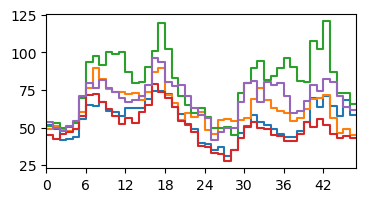

In [36]:
fig, ax = plt.subplots(figsize=(4,2))
for i in range(len(generator.clusters)):
    ax.step(range(48), generator.clusters.iloc[i,:-1].T)

ax.set_xticks(range(0, 48, 6))
ax.set_xlim(0, 47)

In [37]:


if name in waterboards:
    varname = 'Aggregated'
    distributionloader = DistributionLoader(distribution_df, 'Aggregated', valmin=valmin, valmax=valmax)
    bn = BN(val_data, distributionloader, varname='Aggregated', n=48, threshold=None)
    bn.make_structure()
    scenarios = bn(idx, n_scenarios).round(2)
    
    # Mask all negative values to zero
    scenarios[scenarios < 0] = 0

elif name == 'WL':
    varname = 'WL'
    distributionloader = DistributionLoader(distribution_df, 'WL', valmin=valmin, valmax=valmax)
    bn = BN(val_data, distributionloader, varname='WL', n=48, threshold=None)
    bn.make_structure()
    scenarios = bn(idx, n_scenarios).round(2)

elif name == 'DAM':
    varname = 'DAM NL'
    distributionloader = DistributionLoader(distribution_df, 'DAM NL', valmin=valmin, valmax=valmax)
    bn = BN(val_data, distributionloader, varname='DAM NL', n=48, threshold=None)
    bn.make_structure()
    scenarios = bn(idx, n_scenarios).round(2)

scenarios[scenarios > valmax] = valmax
scenarios[scenarios < valmin] = valmin

TypeError: can only concatenate tuple (not "DateOffset") to tuple

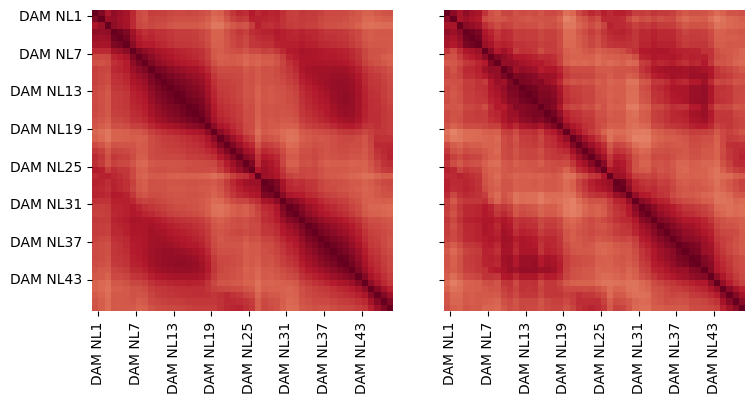

In [26]:
ax = bn.plot_scenarios_R(16)

In [ ]:
energy_clusterer = ReduceForward(x=scenarios.values, cdn=5, dist='energy')
energy_clusterer.reduce_forward()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of  97 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:    0.0s finishe

In [9]:
was_clusterer = ReduceForward(x=scenarios.values, cdn=5, dist='wasserstein')
was_clusterer.reduce_forward()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of  97 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:    0.0s finishe

In [10]:
def plot_clusters(clusterer, ax=None, **kwargs):
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 3))
    cluster_scen_idx = [int(i) for i in clusterer.res[:,0]]
    weights = clusterer.res[:,1]
    for i in range(len(clusterer.x)):
        if not i in cluster_scen_idx:
            if i == 0:
                ax.step(range(1,49), clusterer.x[i,:], color='grey', alpha=0.1, lw=1, label='Original scenarios')
            else:
                ax.step(range(1,49), clusterer.x[i,:], color='grey', alpha=0.1, lw=1)
    
    weight_labels = [f'$w_{i}$ = {weights[i]:.2f}' for i in range(len(weights))]
    for i, j in enumerate(cluster_scen_idx):
        ax.step(range(1,49), clusterer.x[j,:], alpha=1, lw=1, label=weight_labels[i])
        
    # Now add the legend on the top of the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
    ax.set_xlim(1, 48)


NameError: name 'plot_clusters' is not defined

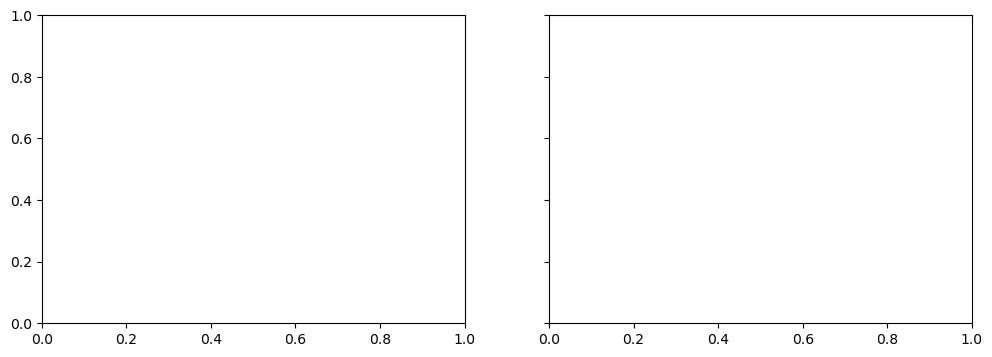

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plot_clusters(energy_clusterer, ax=ax[0])
ax[0].set_xlabel('Forecast leadtime [hours] \n Energy distance clustering')
ax[0].set_ylabel('Discharge [$m^3s^{-1}$]')
plot_clusters(was_clusterer, ax=ax[1])
ax[1].set_xlabel('Forecast leadtime [hours] \n Wasserstein distance clustering')

fig.suptitle(f'Clustered scenarios for {name} - {distribution_df.index[idx]}')
fig.tight_layout()